# Model Training, Tuning and Predictions 

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
)

In [68]:


train_file = "final_training_data.csv"
val_file = "validation_data.csv"
test_file = "testing_data.csv"

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

X_train = train_df.drop(columns=["Popularity_Label"], errors="ignore")
y_train = train_df["Popularity_Label"]
X_val = val_df.drop(columns=["Popularity_Label"], errors="ignore")
y_val = val_df["Popularity_Label"]
X_test = test_df.drop(columns=["Popularity_Label"], errors="ignore")
y_test = test_df["Popularity_Label"]

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



## XGBoost model 

In [69]:

best_xgb = XGBClassifier(
    subsample=0.8,
    reg_lambda=0.5,
    reg_alpha=0,
    n_estimators=500,
    max_depth=12,
    learning_rate=0.1,
    colsample_bytree=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    random_state=42
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {"Fold": [], "Training Accuracy": [], "Validation Accuracy": []}
classwise_results = {"Class": [], "Training Precision": [], "Training Recall": [], "Training F1-Score": [],
                     "Validation Precision": [], "Validation Recall": [], "Validation F1-Score": []}

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train_smote), 1):
    print(f"Running Fold {fold}/10...")

    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]

    best_xgb.fit(X_train_fold, y_train_fold)

    y_train_pred = best_xgb.predict(X_train_fold)
    y_val_pred = best_xgb.predict(X_val_fold)

    train_acc = accuracy_score(y_train_fold, y_train_pred)
    val_acc = accuracy_score(y_val_fold, y_val_pred)

    cv_results["Fold"].append(fold)
    cv_results["Training Accuracy"].append(train_acc)
    cv_results["Validation Accuracy"].append(val_acc)

    train_class_report = classification_report(y_train_fold, y_train_pred, output_dict=True)
    val_class_report = classification_report(y_val_fold, y_val_pred, output_dict=True)

    for class_label in ["0", "1", "2"]:
        classwise_results["Class"].append(class_label)
        classwise_results["Training Precision"].append(train_class_report[class_label]["precision"])
        classwise_results["Training Recall"].append(train_class_report[class_label]["recall"])
        classwise_results["Training F1-Score"].append(train_class_report[class_label]["f1-score"])
        classwise_results["Validation Precision"].append(val_class_report[class_label]["precision"])
        classwise_results["Validation Recall"].append(val_class_report[class_label]["recall"])
        classwise_results["Validation F1-Score"].append(val_class_report[class_label]["f1-score"])

cv_df = pd.DataFrame(cv_results)
cv_df.to_csv("CV_Results.csv", index=False)

classwise_cv_df = pd.DataFrame(classwise_results)
avg_classwise_results = classwise_cv_df.groupby("Class").mean().reset_index()
avg_classwise_results.to_csv("Avg_Classwise_CV_Results.csv", index=False)

print("\nClass-Wise Average CV Results:")
print(avg_classwise_results)

train_accuracy_avg_xgb = np.mean(cv_results["Training Accuracy"])
val_accuracy_avg_xgb = np.mean(cv_results["Validation Accuracy"])

print("\nOverall Accuracy (10-Fold CV):")
print(f" Training Accuracy: {train_accuracy_avg_xgb:.4f}")
print(f" Validation Accuracy: {val_accuracy_avg_xgb:.4f}")

print("\n All results saved:")
print("- CV Results: CV_Results.csv")
print("- Average Class-Wise CV Results: Avg_Classwise_CV_Results.csv")

Running Fold 1/10...
Running Fold 2/10...
Running Fold 3/10...
Running Fold 4/10...
Running Fold 5/10...
Running Fold 6/10...
Running Fold 7/10...
Running Fold 8/10...
Running Fold 9/10...
Running Fold 10/10...

Class-Wise Average CV Results:
  Class  Training Precision  Training Recall  Training F1-Score  \
0     0            0.993066         0.994253           0.993659   
1     1            0.994105         0.992554           0.993329   
2     2            0.999497         0.999860           0.999679   

   Validation Precision  Validation Recall  Validation F1-Score  
0              0.893789           0.906695             0.900190  
1              0.905468           0.885828             0.895532  
2              0.990151           0.997302             0.993712  

Overall Accuracy (10-Fold CV):
 Training Accuracy: 0.9956
 Validation Accuracy: 0.9299

 All results saved:
- CV Results: CV_Results.csv
- Average Class-Wise CV Results: Avg_Classwise_CV_Results.csv



Final Model Performance on Testing Data:
 Accuracy: 0.8926
 F1-score: 0.8923
 Precision: 0.8921
 Recall: 0.8926
 ROC-AUC: 0.9461

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     10423
           1       0.88      0.86      0.87      7051
           2       0.74      0.67      0.70       237

    accuracy                           0.89     17711
   macro avg       0.84      0.82      0.83     17711
weighted avg       0.89      0.89      0.89     17711



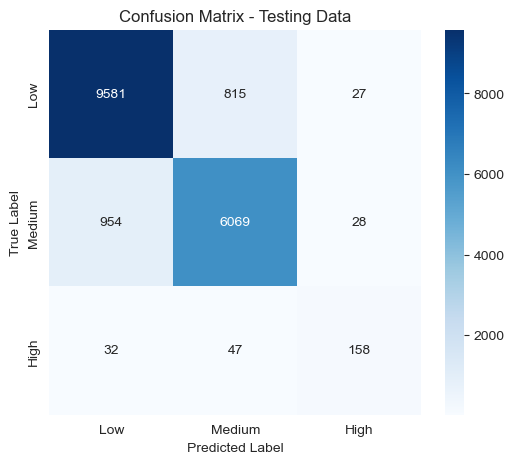

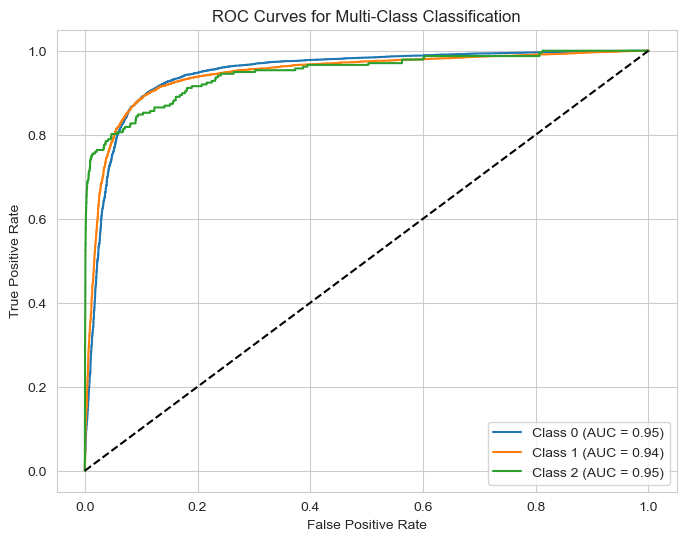


 All results saved:
- Class-Wise Report: Class_Wise_Performance_Testing.csv
- Model Performance Results: Model_Results_Testing.csv
- ROC Curve plotted for all classes.


In [70]:


best_xgb.fit(X_train_scaled, y_train_smote)

y_pred_test = best_xgb.predict(X_test_scaled)
y_pred_probs_test = best_xgb.predict_proba(X_test_scaled) 

test_accuracy_xgb = accuracy_score(y_test, y_pred_test)
f1_xgb = f1_score(y_test, y_pred_test, average="weighted")
precision = precision_score(y_test, y_pred_test, average="weighted")
recall = recall_score(y_test, y_pred_test, average="weighted")
roc_auc_xgb = roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr")

print("\nFinal Model Performance on Testing Data:")
print(f" Accuracy: {test_accuracy_xgb:.4f}")
print(f" F1-score: {f1_xgb:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" ROC-AUC: {roc_auc_xgb:.4f}")

print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred_test))

class_report_df = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()
class_report_df.to_csv("Class_Wise_Performance_Testing.csv", index=True)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Testing Data")
plt.show()

plt.figure(figsize=(8,6))
for i in range(3):  
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_probs_test[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend()
plt.show()

model_results_dict = {
    "Metric": ["Testing Accuracy", "Testing F1-Score", "Testing Precision", "Testing Recall", "Testing ROC-AUC"],
    "Value": [test_accuracy_xgb, f1_xgb, precision, recall, roc_auc_xgb]
}

model_results_df = pd.DataFrame(model_results_dict)
model_results_df.to_csv("Model_Results_Testing.csv", index=False)

print("\n All results saved:")
print("- Class-Wise Report: Class_Wise_Performance_Testing.csv")
print("- Model Performance Results: Model_Results_Testing.csv")
print("- ROC Curve plotted for all classes.")

## Random forest model

In [ ]:


best_rf = RandomForestClassifier(
    n_estimators=300,      
    max_depth=15,          
    min_samples_split=5,    
    min_samples_leaf=2,     
    max_features="sqrt",    
    class_weight="balanced",  
    random_state=42,
    n_jobs=-1
)

# Perform 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {"Fold": [], "Training Accuracy": [], "Validation Accuracy": []}
classwise_results = {"Class": [], "Training Precision": [], "Training Recall": [], "Training F1-Score": [],
                     "Validation Precision": [], "Validation Recall": [], "Validation F1-Score": []}

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train_smote), 1):
    print(f" Running Fold {fold}/10...")

    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]

    best_rf.fit(X_train_fold, y_train_fold)

    y_train_pred = best_rf.predict(X_train_fold)
    y_val_pred = best_rf.predict(X_val_fold)

    train_acc = accuracy_score(y_train_fold, y_train_pred)
    val_acc = accuracy_score(y_val_fold, y_val_pred)

    cv_results["Fold"].append(fold)
    cv_results["Training Accuracy"].append(train_acc)
    cv_results["Validation Accuracy"].append(val_acc)

    train_class_report = classification_report(y_train_fold, y_train_pred, output_dict=True)
    val_class_report = classification_report(y_val_fold, y_val_pred, output_dict=True)

    for class_label in ["0", "1", "2"]:
        classwise_results["Class"].append(class_label)
        classwise_results["Training Precision"].append(train_class_report[class_label]["precision"])
        classwise_results["Training Recall"].append(train_class_report[class_label]["recall"])
        classwise_results["Training F1-Score"].append(train_class_report[class_label]["f1-score"])
        classwise_results["Validation Precision"].append(val_class_report[class_label]["precision"])
        classwise_results["Validation Recall"].append(val_class_report[class_label]["recall"])
        classwise_results["Validation F1-Score"].append(val_class_report[class_label]["f1-score"])

cv_df = pd.DataFrame(cv_results)
cv_df.to_csv("RF_CV_Results.csv", index=False)

classwise_cv_df = pd.DataFrame(classwise_results)
avg_classwise_results = classwise_cv_df.groupby("Class").mean().reset_index()
avg_classwise_results.to_csv("RF_Avg_Classwise_CV_Results.csv", index=False)

print("\n Class-Wise Average CV Results:")
print(avg_classwise_results)

train_accuracy_avg_rf = np.mean(cv_results["Training Accuracy"])
val_accuracy_avg_rf = np.mean(cv_results["Validation Accuracy"])

print("\nOverall Accuracy (10-Fold CV):")
print(f" Training Accuracy: {train_accuracy_avg2:.4f}")
print(f" Validation Accuracy: {val_accuracy_avg2:.4f}")

print("\n All results saved:")
print("- CV Results: RF_CV_Results.csv")
print("- Average Class-Wise CV Results: RF_Avg_Classwise_CV_Results.csv")

 Running Fold 1/10...
 Running Fold 2/10...
 Running Fold 3/10...
 Running Fold 4/10...
 Running Fold 5/10...
 Running Fold 6/10...
 Running Fold 7/10...
 Running Fold 8/10...
 Running Fold 9/10...


In [ ]:


best_rf.fit(X_train_scaled, y_train_smote)

y_pred_test = best_rf.predict(X_test_scaled)
y_pred_probs_test = best_rf.predict_proba(X_test_scaled)  

test_accuracy_rf = accuracy_score(y_test, y_pred_test)
f1_rf = f1_score(y_test, y_pred_test, average="weighted")
precision = precision_score(y_test, y_pred_test, average="weighted")
recall = recall_score(y_test, y_pred_test, average="weighted")
roc_auc_rf = roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr")

print("\n Final Model Performance on Testing Data:")
print(f" Accuracy: {test_accuracy_rf:.4f}")
print(f" F1-score: {f1_rf:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" ROC-AUC: {roc_auc_rf:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_test))

class_report_df = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()
class_report_df.to_csv("RF_Class_Wise_Performance_Testing.csv", index=True)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest - Confusion Matrix (Testing Data)")
plt.show()

plt.figure(figsize=(8,6))
for i in range(3):  # Assuming three classes: 0, 1, and 2
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_probs_test[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification (Random Forest)")
plt.legend()
plt.show()

model_results_dict = {
    "Metric": ["Testing Accuracy", "Testing F1-Score", "Testing Precision", "Testing Recall", "Testing ROC-AUC"],
    "Value": [test_accuracy_rf, f1_rf, precision, recall, roc_auc_rf]
}

model_results_df = pd.DataFrame(model_results_dict)
model_results_df.to_csv("RF_Model_Results_Testing.csv", index=False)

print("\n All results saved:")
print("- Class-Wise Report: RF_Class_Wise_Performance_Testing.csv")
print("- Model Performance Results: RF_Model_Results_Testing.csv")
print("- ROC Curve plotted for all classes.")

## Model Comparison 

In [ ]:
y_pred_xgb = best_xgb.predict(X_test_scaled)  # XGBoost Predictions
y_pred_rf = best_rf.predict(X_test_scaled)    # Random Forest Predictions

In [ ]:


xgb_cm = confusion_matrix(y_test, y_pred_xgb)
rf_cm = confusion_matrix(y_test, y_pred_rf)

xgb_cm = xgb_cm.astype(int)
rf_cm = rf_cm.astype(int)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], 
            yticklabels=["Low", "Medium", "High"], ax=ax[0])
ax[0].set_title("XGBoost - Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Low", "Medium", "High"], 
            yticklabels=["Low", "Medium", "High"], ax=ax[1])
ax[1].set_title("Random Forest - Confusion Matrix")
ax[1].set_xlabel("Predicted Label")
ax[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [ ]:


best_xgb = XGBClassifier(
    subsample=0.8,
    reg_lambda=0.5,
    reg_alpha=0,
    n_estimators=500,
    max_depth=12,
    learning_rate=0.1,
    colsample_bytree=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    random_state=42
)

best_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


best_xgb.fit(X_train_scaled, y_train_smote)
best_rf.fit(X_train_scaled, y_train_smote)

y_pred_probs_xgb = best_xgb.predict_proba(X_test_scaled)
y_pred_probs_rf = best_rf.predict_proba(X_test_scaled)

plt.figure(figsize=(8, 6))

for i in range(3):  # Assuming 3 classes: 0 (Low), 1 (Medium), 2 (High)
    fpr_xgb, tpr_xgb, _ = roc_curve((y_test == i).astype(int), y_pred_probs_xgb[:, i])
    fpr_rf, tpr_rf, _ = roc_curve((y_test == i).astype(int), y_pred_probs_rf[:, i])

    plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label=f'XGBoost Class {i} (AUC = {auc(fpr_xgb, tpr_xgb):.2f})')
    plt.plot(fpr_rf, tpr_rf, linestyle='--', label=f'Random Forest Class {i} (AUC = {auc(fpr_rf, tpr_rf):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: XGBoost vs. Random Forest")
plt.legend()
plt.show()

In [ ]:
i

models = ["XGBoost", "Random Forest"]

training_accuracy = [train_accuracy_avg_xgb, train_accuracy_avg_rf]
validation_accuracy = [val_accuracy_avg_xgb, val_accuracy_avg_rf]
testing_accuracy = [test_accuracy_xgb, test_accuracy_rf]

bar_width = 0.2
x = np.arange(len(models))

colors = {
    "training": "#6baed6",  # Matte cyan
    "validation": "#9e9ac8",  # Matte purple
    "testing": "#bcbddc"  # Matte violet
}

plt.figure(figsize=(8, 8))
plt.bar(x - bar_width, training_accuracy, bar_width, label="Training Accuracy", color=colors["training"])
plt.bar(x, validation_accuracy, bar_width, label="Validation Accuracy", color=colors["validation"])
plt.bar(x + bar_width, testing_accuracy, bar_width, label="Testing Accuracy", color=colors["testing"])

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Training, Validation, and Testing Accuracy")
plt.xticks(x, models)
plt.ylim(0.7, 1.0)
plt.legend()

plt.show()

In [ ]:

results = {
    "Model": ["XGBoost", "Random Forest"],
    "Training Accuracy": [round(train_accuracy_avg_xgb, 4), round(train_accuracy_avg_rf, 4)],
    "Validation Accuracy": [round(val_accuracy_avg_xgb, 4), round(val_accuracy_avg_rf, 4)],
    "Testing Accuracy": [round(test_accuracy_xgb, 4), round(test_accuracy_rf, 4)],
    "F1-Score": [round(f1_xgb, 4), round(f1_rf, 4)],
    "ROC-AUC": [round(roc_auc_xgb, 4), round(roc_auc_rf, 4)]
}

df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid")
table = plt.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.axis("off")
plt.title("Model Performance Comparison", fontsize=12, fontweight="bold")
plt.show()